## Intro to gaussian processes with PyMC!

Author: Johan Thor with code proudly stolen from Simon Hedström



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("sodra.mplstyle")

import arviz as az
import pymc as pm

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


In [2]:
# Below functions are written by Simon:


def delinearize(x):
    """Performs a linear regression and subtracts it from the signal."""
    k, m = np.polyfit(np.arange(len(x)), x, 1)
    return x - (k * np.arange(len(x)) + m)


def standardize(x):
    """Standardizes the signal using the sample mean and standard deviation."""
    std = np.std(x)
    if std == 0:
        std = 1
    return (x - np.mean(x)) / std


# Creating our initial problem

We generate the following signals $s_i$:
1. Random walk. Exponentially smoothed with a factor of $\frac{1}{30}$. Delinearized. Standardized. 
2. Sine wave with boolean logic $sin(t) > 0$. Standardized.
    
    
We construct our prediction target $y = standardize(s_1 + s_2)$.   
On top of that we also distort out target by adding noise $v \sim exp(\frac{1}{4})$

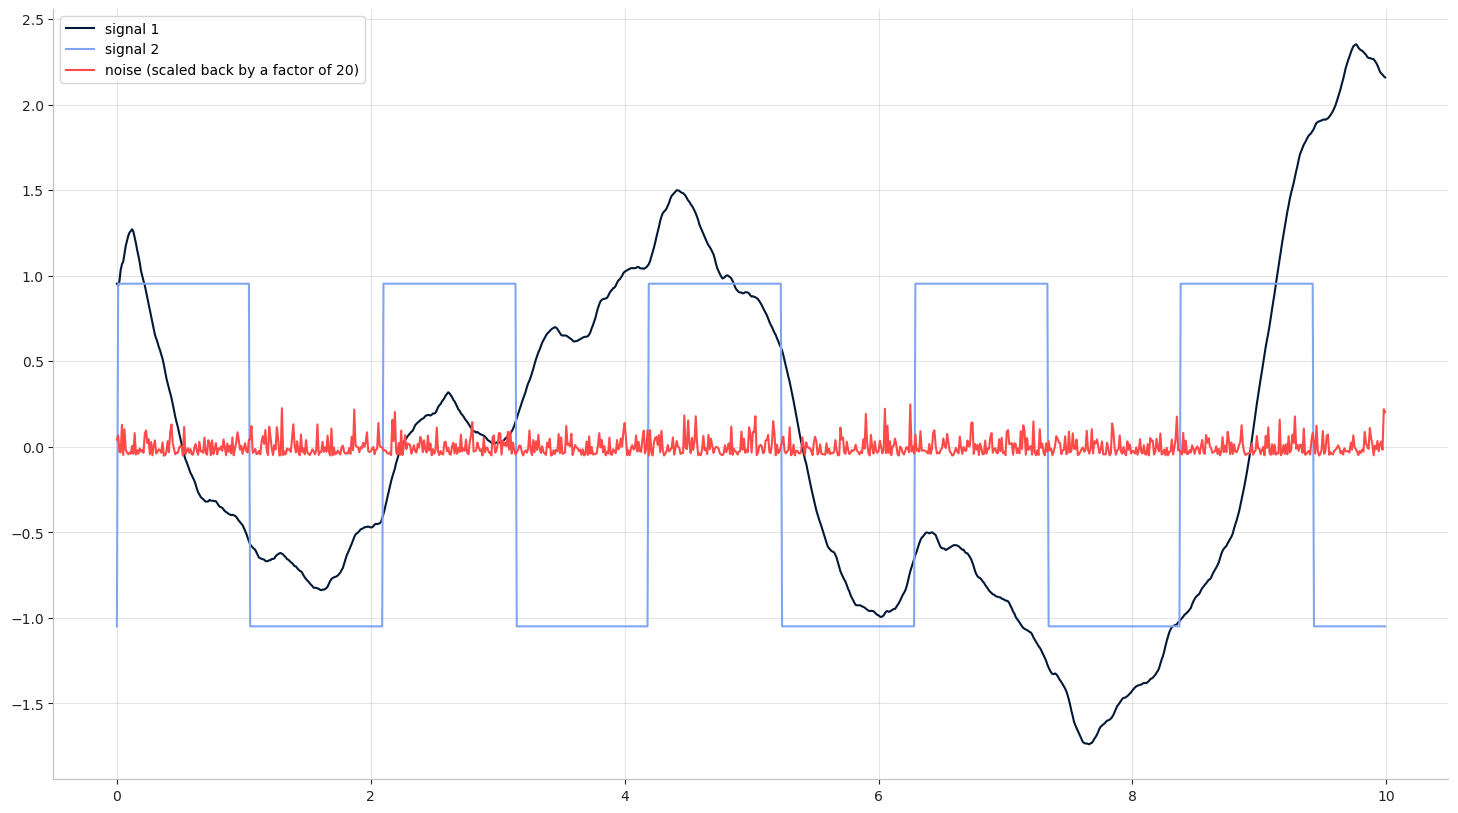

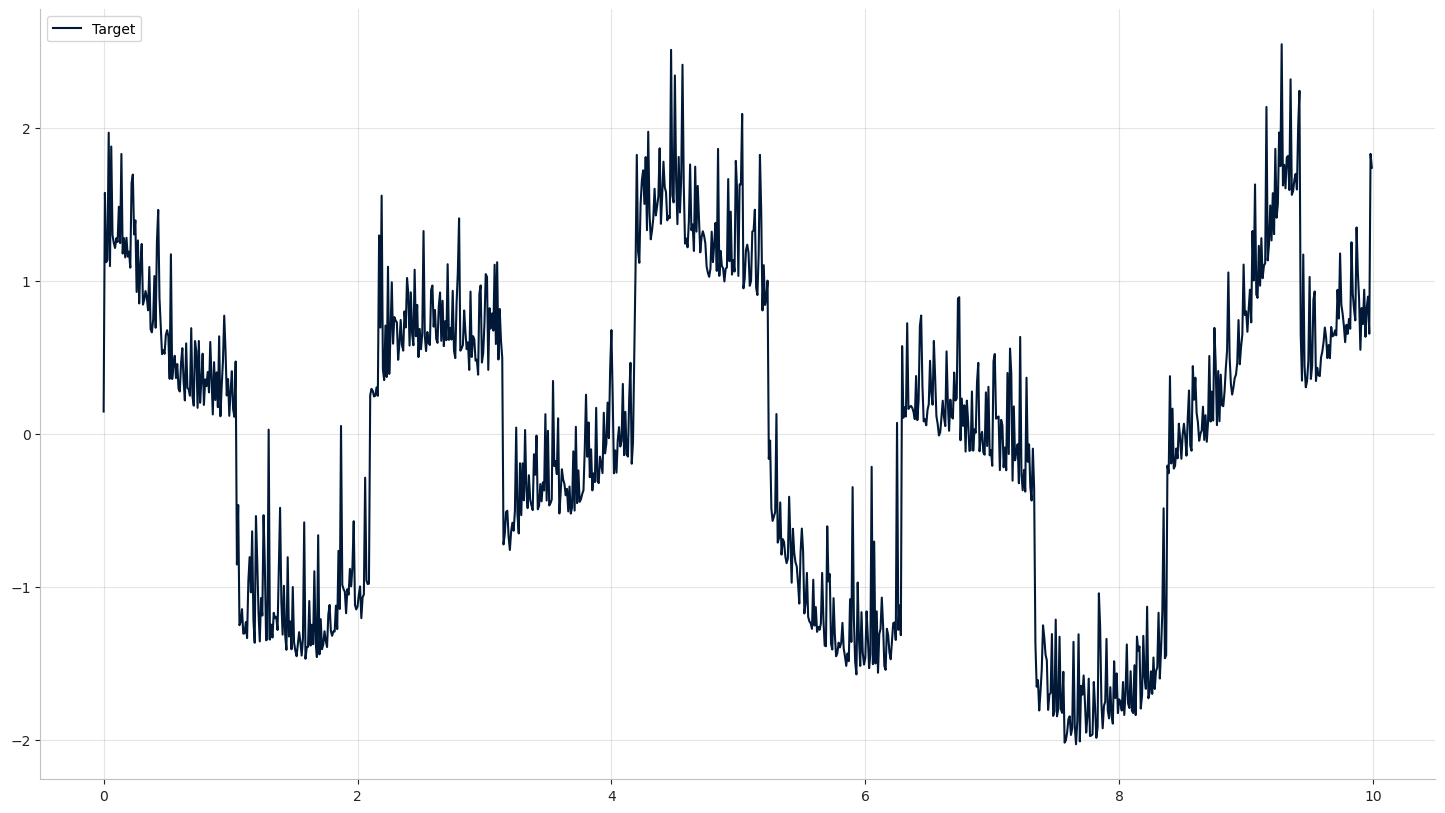

In [4]:
np.random.seed(RANDOM_SEED)


N = 1000
dt = 0.01
noise_factor = 1 / 4

# Time
t = dt * np.arange(N)

# Signal 1
signal1 = np.cumsum(np.random.randn(N))
signal1 = pd.Series(signal1).ewm(alpha=1 / 30).mean().values
signal1 = standardize(delinearize(signal1))

# Signal 2
signal2 = standardize(np.sin(3*t) > 0)

# Target
target = standardize(signal1 + signal2)

# Noise to target
noise = standardize(-np.log(np.random.rand(N)) - 1)
target += noise * noise_factor

# Plot data
fig, ax = plt.subplots()
ax.plot(t, signal1, label="signal 1")
ax.plot(t, signal2, label="signal 2")
ax.plot(t, noise / 20, label="noise (scaled back by a factor of 20)")
ax.legend()
plt.show()

# Plot target
fig, ax = plt.subplots()
ax.plot(t, target, label="Target")
ax.legend()
plt.show()


(array([101., 104.,  89.,  89.,  62.,  70.,  59.,  44.,  33.,  34.,  30.,
         31.,  29.,  23.,  19.,  21.,  13.,  18.,  12.,  14.,  11.,  12.,
          8.,  13.,  12.,   3.,   3.,   6.,   5.,   4.,   4.,   4.,   2.,
          2.,   3.,   0.,   0.,   0.,   4.,   1.,   1.,   0.,   2.,   0.,
          1.,   2.,   1.,   0.,   0.,   1.]),
 array([-1.02376289, -0.90422222, -0.78468154, -0.66514087, -0.5456002 ,
        -0.42605953, -0.30651885, -0.18697818, -0.06743751,  0.05210317,
         0.17164384,  0.29118451,  0.41072519,  0.53026586,  0.64980653,
         0.76934721,  0.88888788,  1.00842855,  1.12796923,  1.2475099 ,
         1.36705057,  1.48659124,  1.60613192,  1.72567259,  1.84521326,
         1.96475394,  2.08429461,  2.20383528,  2.32337596,  2.44291663,
         2.5624573 ,  2.68199798,  2.80153865,  2.92107932,  3.04062   ,
         3.16016067,  3.27970134,  3.39924201,  3.51878269,  3.63832336,
         3.75786403,  3.87740471,  3.99694538,  4.11648605,  4.23602673,
 

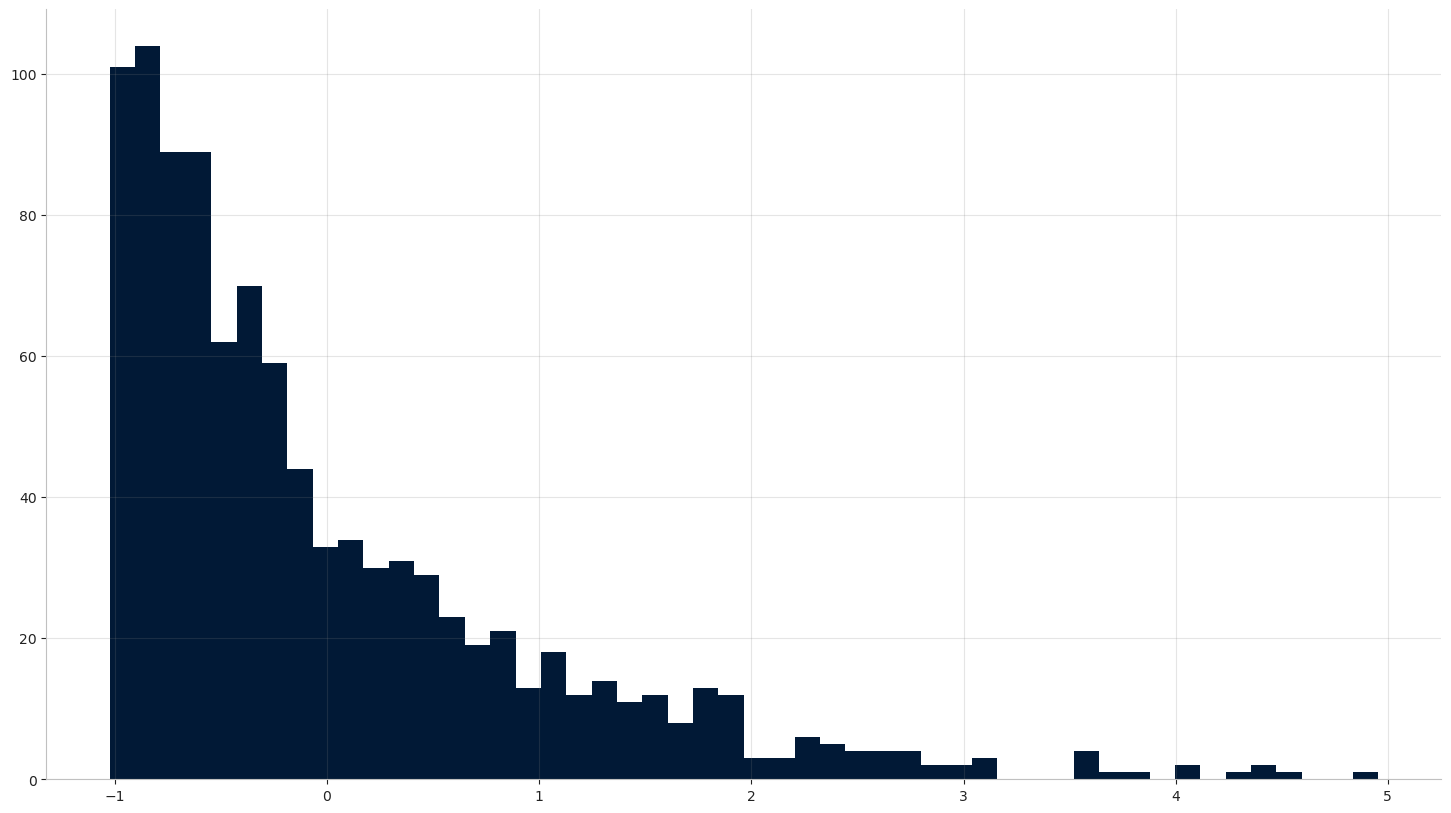

In [7]:
plt.hist(noise, bins=50)


In [8]:
# Create X and Y
x = np.vstack([signal1, signal2]).T
y = target.reshape(-1, 1)

n_train = N // 3

# Get training set
t_train = t[:n_train]
x_train = x[:n_train]
y_train = y[:n_train]

# Get remaining set, predict
t_rest = t[n_train:]
x_rest = x[n_train:]
y_rest = y[n_train:]
